In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image


In [ ]:
# Define constants
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
NUM_CLASSES = 4
EPOCHS = 10

# Define the transforms for the training and validation sets
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [ ]:
# Load the dataset
dataset_path = '/content/drive/MyDrive/Machine Learning Project/dataset_13'
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Split the dataset into training (80%) and validation (20%) sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# Load the pretrained InceptionV3 model
model = models.inception_v3(pretrained=True)

# Modify the classifier to match the number of classes in your dataset
num_classes = 4
model.fc = nn.Linear(model.fc.in_features, num_classes)
model.aux_logits = False  # Disable auxiliary classifier

# Move the model to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Freeze the layers of InceptionV3 model
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.0001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:00<00:00, 189MB/s] 


In [ ]:
# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")


Epoch 1/10, Loss: 1.4233335157235463
Validation Loss: 1.4019155104955037, Accuracy: 14.583333333333334%
Epoch 2/10, Loss: 1.3845878442128499
Validation Loss: 1.3880755106608074, Accuracy: 18.75%
Epoch 3/10, Loss: 1.3355546693007152
Validation Loss: 1.3497087558110554, Accuracy: 31.25%
Epoch 4/10, Loss: 1.3133917848269145
Validation Loss: 1.3230563004811604, Accuracy: 40.625%
Epoch 5/10, Loss: 1.2815239429473877
Validation Loss: 1.281043569246928, Accuracy: 53.125%
Epoch 6/10, Loss: 1.2586900691191356
Validation Loss: 1.2397770881652832, Accuracy: 68.75%
Epoch 7/10, Loss: 1.2340149283409119
Validation Loss: 1.2101497252782185, Accuracy: 71.875%
Epoch 8/10, Loss: 1.2180571953455608
Validation Loss: 1.1851833661397297, Accuracy: 77.08333333333333%
Epoch 9/10, Loss: 1.1775165398915608
Validation Loss: 1.163783033688863, Accuracy: 78.125%
Epoch 10/10, Loss: 1.1583338479201
Validation Loss: 1.1447795232137044, Accuracy: 78.125%


In [ ]:
# Unfreeze the last few layers and fine-tune the model
for param in model.parameters():
    param.requires_grad = True

# Re-compile the model with a lower learning rate
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Fine-tune the model
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    # Validation step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader)}, Accuracy: {100 * correct / total}%")


Epoch 1/10, Loss: 1.091179351011912
Validation Loss: 1.0390713214874268, Accuracy: 79.16666666666667%
Epoch 2/10, Loss: 0.9449805070956548
Validation Loss: 0.9376926024754842, Accuracy: 83.33333333333333%
Epoch 3/10, Loss: 0.8109072198470434
Validation Loss: 0.8333902955055237, Accuracy: 83.33333333333333%
Epoch 4/10, Loss: 0.7155324667692184
Validation Loss: 0.7400654355684916, Accuracy: 84.375%
Epoch 5/10, Loss: 0.6142718344926834
Validation Loss: 0.6672669251759847, Accuracy: 85.41666666666667%
Epoch 6/10, Loss: 0.5246489197015762
Validation Loss: 0.6047750314076742, Accuracy: 86.45833333333333%
Epoch 7/10, Loss: 0.4739197790622711
Validation Loss: 0.5541157523790995, Accuracy: 87.5%
Epoch 8/10, Loss: 0.38574548065662384
Validation Loss: 0.5157317817211151, Accuracy: 88.54166666666667%
Epoch 9/10, Loss: 0.3347258046269417
Validation Loss: 0.47420307993888855, Accuracy: 89.58333333333333%
Epoch 10/10, Loss: 0.2904396429657936
Validation Loss: 0.44483158985773724, Accuracy: 88.5416666

In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'brain_tumor_classifier.pth')

# Load the model for inference
model.load_state_dict(torch.load('brain_tumor_classifier.pth'))
model.eval()


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


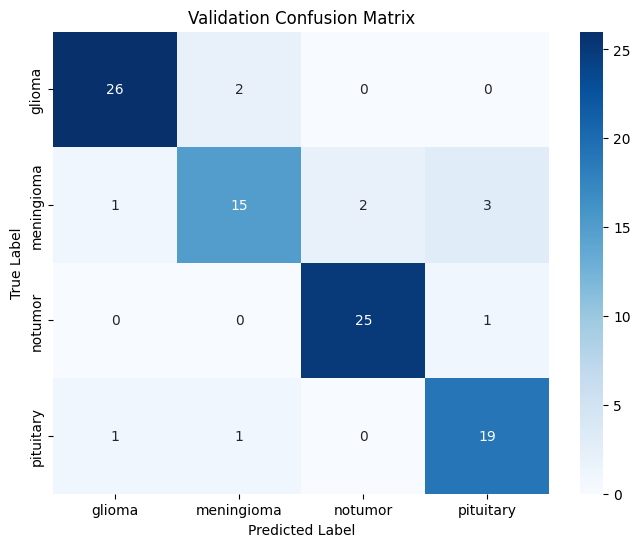

              precision    recall  f1-score   support

      glioma       0.93      0.93      0.93        28
  meningioma       0.83      0.71      0.77        21
     notumor       0.93      0.96      0.94        26
   pituitary       0.83      0.90      0.86        21

    accuracy                           0.89        96
   macro avg       0.88      0.88      0.88        96
weighted avg       0.88      0.89      0.88        96



In [ ]:
# Make predictions on the validation data
val_predictions = []
val_true_classes = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        val_predictions.extend(preds.cpu().numpy())
        val_true_classes.extend(labels.numpy())

# Compute the confusion matrix
val_conf_matrix = confusion_matrix(val_true_classes, val_predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(val_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.dataset.classes, yticklabels=train_dataset.dataset.classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Validation Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(val_true_classes, val_predictions, target_names=train_dataset.dataset.classes))


# Calculate TP, TN, FP, FN
class_names = train_dataset.dataset.classes
table_data = []
for i, class_name in enumerate(class_names):
    tp = val_conf_matrix[i, i]
    fp = np.sum(val_conf_matrix[:, i]) - tp
    fn = np.sum(val_conf_matrix[i, :]) - tp
    tn = np.sum(val_conf_matrix) - tp - fp - fn
    table_data.append([class_name, tp, tn, fp, fn])



In [ ]:
# # Display the TP/TN/FP/FN table
# headers = ["Class", "True Positive", "True Negative", "False Positive", "False Negative"]
# plt.subplot(1, 2, 2)
# plt.axis('off')
# plt.table(cellText=table_data, colLabels=headers, cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# plt.tight_layout()
# plt.show()


# # Calculate overall TP, TN, FP, FN
# tp_total = np.trace(val_conf_matrix)
# tn_total = np.sum(np.diagonal(val_conf_matrix)) - tp_total
# fp_total = np.sum(val_conf_matrix, axis=0) - np.diag(val_conf_matrix)
# fn_total = np.sum(val_conf_matrix, axis=1) - np.diag(val_conf_matrix)

# # Display the overall TP/TN/FP/FN metrics
# overall_metrics = {
#     "True Positive": tp_total,
#     "True Negative": tn_total,
#     "False Positive": fp_total.sum(),
#     "False Negative": fn_total.sum()
# }

# plt.subplot(1, 2, 2)
# plt.axis('off')
# plt.table(cellText=[[key, overall_metrics[key]] for key in overall_metrics.keys()], colLabels=["Metric", "Count"], cellLoc='center', loc='center', bbox=[0, 0, 1, 1])

# plt.tight_layout()
# plt.show()

# # Print overall metrics
# print(f"Overall True Positive: {tp_total}")
# print(f"Overall True Negative: {tn_total}")
# print(f"Overall False Positive: {fp_total.sum()}")
# print(f"Overall False Negative: {fn_total.sum()}")

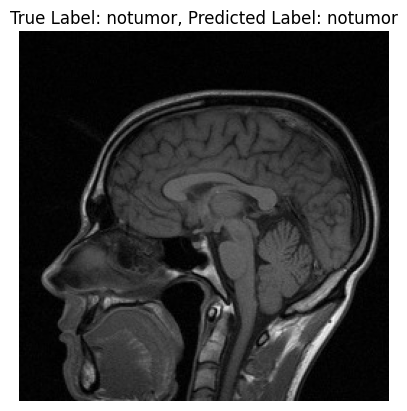

True Label: notumor
Predicted Label: notumor


In [ ]:
import random, os


# Define a function to predict the class of a single image
def predict_image(image_path, model, transform):
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
        return predicted.item()

# Predict a random image from the dataset
random_image_path, _ = random.choice(full_dataset.samples)
predicted_class = predict_image(random_image_path, model, transform)

# Extract the true label
true_label_name = os.path.basename(os.path.dirname(random_image_path))
true_label_idx = full_dataset.class_to_idx[true_label_name]

# Load the image for display
image = Image.open(random_image_path)
plt.imshow(image)
plt.title(f'True Label: {full_dataset.classes[true_label_idx]}, Predicted Label: {full_dataset.classes[predicted_class]}')
plt.axis('off')
plt.show()

# Print true and predicted labels
print(f'True Label: {full_dataset.classes[true_label_idx]}')
print(f'Predicted Label: {full_dataset.classes[predicted_class]}')


